In [1]:
import pandas as pd
import bagpy
import pickle
import pathlib
import pinocchio as pin
import hppfcl as fcl

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from panda_loader import load_panda

/tmp/ipykernel_32241/3611703804.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Convert ROS bag file to pickle

In [13]:
def extract_data(in_file: str, out_file: str) -> pd.DataFrame:
    bag = bagpy.bagreader(in_file)
    topic_data = []
    for topic in bag.topics:
        df = pd.read_csv(bag.message_by_topic(topic))
        topic_data.append(df[df.columns.drop(list(df.filter(regex='head')))])

    with open(out_file, "wb") as handle:
        pickle.dump(topic_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


bag_path_col_pair = pathlib.Path().resolve() / "bags/col_pair_comparison"
pkl_path = pathlib.Path().resolve() / "pickle/col_pair_comparison"
pathlib.Path(bag_path_col_pair).mkdir(parents=True, exist_ok=True)
for file in bag_path_col_pair.glob("*.bag"):
    extract_data(file.as_posix(), pkl_path / file.with_suffix('.pkl').name)

[INFO]  Data folder /home/arthur/Desktop/Code/forks/panda_torque_mpc/post-treatment/bags/col_pair_comparison/2024-01-22-21-43-19_2_collision_pairs already exists. Not creating.


FileNotFoundError: [Errno 2] No such file or directory: '/home/arthur/Desktop/Code/forks/panda_torque_mpc/post-treatment/pickle/col_pair_comparison/2024-01-22-21-43-19_2_collision_pairs.pkl'

In [6]:
for file in pkl_path.glob("*.pkl"):
    with open(file, "rb") as handle:
        b = pickle.load(handle)

In [7]:
print(b[1]["feedforward.data"][0])

NameError: name 'b' is not defined

https://seaborn.pydata.org/examples/grouped_boxplot.html this one is nice


/home/krzysiek/miniconda3/envs/analyze/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'TODO NAME THIS AXIS')

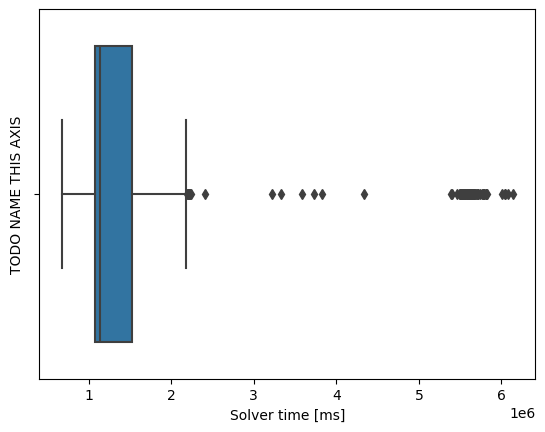

In [104]:
sns.boxplot(b[2], x = "data.nsecs")
plt.xlabel("Solver time [ms]")
plt.ylabel("TODO NAME THIS AXIS")

### Distance to obstacle

In [2]:
rmodel, cmodel = load_panda()

In [3]:
def compute_minimal_distances_between_collision_pairs(q):

    # Creates data models
    rdata = rmodel.createData()
    cdata = cmodel.createData()

    # Updating the models
    pin.framesForwardKinematics(rmodel, rdata, q)
    pin.updateGeometryPlacements(rmodel, rdata, cmodel, cdata, q)

    # HPPFCL Queries
    req = fcl.DistanceRequest()
    res = fcl.DistanceResult()

    # List storing all the distances, from the first collision pair to the last in the order of addition in the collision model
    list_dist = []
    # Going through all the collision pairs
    for col_pair in cmodel.collisionPairs:
        # Geometry objects ID in the collision model
        pair1_id = col_pair.first
        pair2_id = col_pair.second

        dist = fcl.distance(
            cmodel.geometryObjects[pair1_id].geometry,
            cdata.oMg[pair1_id],
            cmodel.geometryObjects[pair2_id].geometry,
            cdata.oMg[pair2_id],
            req,
            res,
        )
        list_dist.append(dist)
    return list_dist

In [11]:
q = pin.neutral(rmodel)
 
list_dist = compute_minimal_distances_between_collision_pairs(q)

print(f"panda2_rightfinger_0-obstacle : {list_dist[0]} \n ")
print(f"panda2_leftfinger_0-obstacle : {list_dist[1]} \n ")
print(f"panda2_link7_sc_1-obstacle : {list_dist[2]} \n ")
print(f"panda2_link7_sc_4-obstacle : {list_dist[3]} \n ")

panda2_rightfinger_0-obstacle : 0.7587475966527489 
 
panda2_leftfinger_0-obstacle : 0.7412001320788593 
 
panda2_link7_sc_1-obstacle : 0.7930169796299097 
 
panda2_link7_sc_4-obstacle : 0.7745538637757287 
 


In [ ]:
sns.lineplot(b[2], x = "data.nsecs")
plt.xlabel("Solver time [ns]")
plt.ylabel("TODO NAME THIS AXIS")

In [137]:
list(eval(b[3]["joint_state.position"][0]))

[0.0362813099492616,
 0.46806776229276537,
 0.2767158982469953,
 -2.033111264234318,
 -0.19712173451223602,
 2.461874062370896,
 1.2236552863195174]